In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# for lat/lon conversion
import utm

# for SRTM data download
# - install (on system, not within python environment): `brew install gdal`
# - install with `pip install elevation`
# - check with `eio selfcheck`
import elevation

# for surface mesh manipulation
# - install with `pip install numpy-stl`
from stl import mesh

/Users/equon/anaconda3/envs/forge/lib/python3.7/importlib/_bootstrap.py:219: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return f(*args, **kwds)


# Terrain-Resolved Domain Setup
This notebook will generate a surface geometry file to be used by the microscale solver (e.g., SOWFA) to conform the solver domain to the terrain (e.g., with `moveDynamicMesh`).

In [3]:
# setUp parameters
xMin = -6000.0
yMin = -1500.0
xMax = 4000.0
yMax = 1500.0

In [4]:
# for estimating some reference parameters
ds = 10.

## Transform domain
Center at Physics Site met mast 12

In [5]:
PS12 = (45.638004, -120.642973, 495)

In [6]:
easting, northing, zone_number, zone_letter = utm.from_latlon(*PS12[:2])

In [7]:
xyz = [easting, northing, PS12[2]]
xyz

[683695.4958836242, 5056530.623780903, 495]

## Setup terrain
Modify reference STL file to transition from flat to complex terrain near inlet and side boundaries

In [8]:
fringe_NS_width = 500. 
fringe_NS_offset = 10*ds
flat_inlet_length = 1000.
transition_length = 1000.

In [9]:
stlpath = '/Users/equon/WakeDynamics/Biglow_NW/Wasco.fine.stl'

### read mesh
(downloaded by Matt? from SRTM in separate matlab script), try to understand mesh format

In [10]:
msh = mesh.Mesh.from_file(stlpath)

In [11]:
msh.x.shape, msh.y.shape, msh.z.shape

((6756430, 3), (6756430, 3), (6756430, 3))

In [12]:
np.all(msh.x == msh.vectors[:,:,0])

True

In [13]:
np.all(msh.v0 == msh.vectors[:,0,:])

True

In [14]:
msh.vectors[:,:,0] # x

array([[-14474., -14496., -14495.],
       [-22825., -22804., -22825.],
       [-26004., -25982., -25983.],
       ...,
       [ 16523.,  16502.,  16524.],
       [ 16523.,  16524.,  16545.],
       [ 16524.,  16546.,  16545.]], dtype=float32)

In [15]:
msh.vectors[:,:,1] # y

array([[ 18127.,  18126.,  18095.],
       [-13254., -13223., -13224.],
       [  -798.,   -797.,   -767.],
       ...,
       [-23643., -23675., -23674.],
       [-23643., -23674., -23643.],
       [-23674., -23673., -23643.]], dtype=float32)

In [16]:
msh.vectors[:,:,2] # z

array([[518., 520., 521.],
       [446., 443., 444.],
       [322., 320., 311.],
       ...,
       [603., 605., 604.],
       [603., 604., 603.],
       [604., 603., 603.]], dtype=float32)

### plot what we've read in

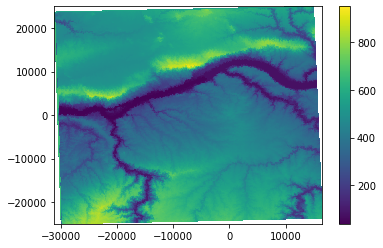

In [52]:
cmesh = plt.pcolormesh(msh.x, msh.y, msh.z)
cbar = plt.colorbar()

In [53]:
elev_range = cmesh.get_clim()
elev_range

(39.0, 950.0)

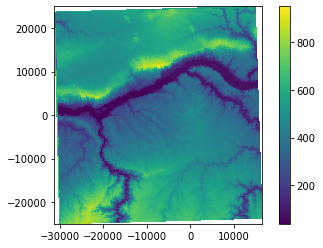

In [19]:
plt.pcolormesh(msh.x, msh.y, msh.z)#, vmin=322, vmax=494)
plt.xlim((xMin,xMax))
plt.ylim((yMin,yMax))
plt.axis('scaled')
plt.colorbar()

In [20]:
# select faces within the LES domain
offset = 100*ds
les_domain = \
      np.all(msh.x > xMin-offset, axis=1) & np.all(msh.x < xMax+offset, axis=1) \
    & np.all(msh.y > yMin-offset, axis=1) & np.all(msh.y < yMax+offset, axis=1)

In [21]:
elevmin, elevmax = np.min(msh.z[les_domain,:]), np.max(msh.z[les_domain,:])
elevmin, elevmax

(301.0, 494.0)

(-6999.0, 4999.0, -2499.0, 2499.0)

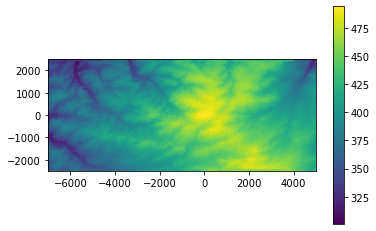

In [22]:
fig0, ax0 = plt.subplots()
pcm0 = ax0.pcolormesh(msh.x[les_domain,:], msh.y[les_domain,:], msh.z[les_domain,:],
                     )#vmin=elev_range[0], vmax=elev_range[1])
fig0.colorbar(pcm0, ax=ax0)
ax0.axis('scaled')

### now, create the new mesh

In [23]:
newmsh = mesh.Mesh(np.zeros(np.count_nonzero(les_domain), dtype=mesh.Mesh.dtype))

In [24]:
newmsh.vectors = msh.vectors[les_domain,:,:]
newmsh.save('surface_step0.stl')

In [25]:
newmsh.z

array([[442., 442., 442.],
       [367., 369., 366.],
       [422., 419., 417.],
       ...,
       [358., 358., 356.],
       [359., 361., 362.],
       [359., 363., 363.]], dtype=float32)

In [26]:
fringe_south = np.all(newmsh.y < (yMin + fringe_NS_width + fringe_NS_offset), axis=1)
fringe_north = np.all(newmsh.y > (yMax - fringe_NS_width - fringe_NS_offset), axis=1)
fringe_NS = fringe_north | fringe_south

In [27]:
flat_inlet = np.all(newmsh.x < (xMin + 1000.), axis=1)

In [28]:
edge_regions = flat_inlet | fringe_NS

In [29]:
# this is the mean surface elevation around the edges of the domain
#   and should coincide with the bottom of the precursor domain
edge_elev = np.mean(newmsh.z[edge_regions,:])
edge_elev = float(int(edge_elev)) # round to nice number
edge_elev

406.0

test scaling function in 1D

In [30]:
# symmetric
ymid = (yMin + yMax) / 2

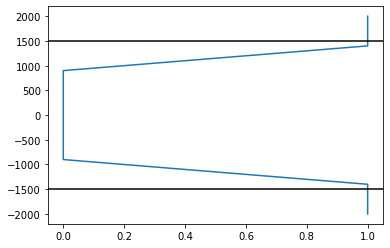

In [31]:
y = np.arange(-2000,2001,ds)
s = np.minimum(
        np.maximum(
            (np.abs(y-ymid) - (yMax-ymid - fringe_NS_width - fringe_NS_offset)) / fringe_NS_width,
        0),
    1)
fig,ax = plt.subplots()
plt.plot(s,y)
ax.axhline(yMin,color='k',ls='-')
ax.axhline(yMax,color='k',ls='-')

#### 1. blend terrain in fringe regions at the north and south boundaries

In [32]:
scaling_NS = \
    np.minimum(
        np.maximum(
            (np.abs(newmsh.y-ymid) - (yMax-ymid - fringe_NS_width - fringe_NS_offset)) / fringe_NS_width,
        0),1)

In [33]:
newmsh.z = scaling_NS*edge_elev + (1-scaling_NS)*newmsh.z

In [34]:
newmsh.save('surface_step1.stl')

#### 2. blend terrain near inlet boundary

In [35]:
x0 = xMin + flat_inlet_length
#x1 = x0 + transition_length
scaling_inlet = np.minimum(np.maximum( (newmsh.x - x0) / transition_length, 0), 1)

In [36]:
newmsh.z = (1-scaling_inlet)*edge_elev + scaling_inlet*newmsh.z

In [37]:
newmsh.save('surface_step2.stl')

In [38]:
elev_delta = elevmax - edge_elev
edge_elev-elev_delta, edge_elev+elev_delta

(318.0, 494.0)

CPU times: user 376 ms, sys: 12.4 ms, total: 389 ms
Wall time: 390 ms


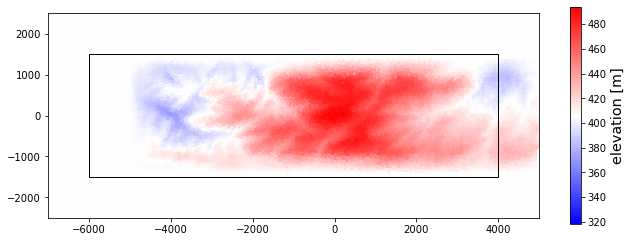

In [133]:
%%time
fig, ax = plt.subplots(figsize=(11,4))
pcm = ax.pcolormesh(newmsh.x, newmsh.y, newmsh.z, cmap='bwr',
                    vmin=edge_elev-elev_delta, vmax=edge_elev+elev_delta)
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('elevation [m]',fontsize='x-large')

rect = patches.Rectangle(
    (xMin,yMin), (xMax-xMin), (yMax-yMin),
    fill=False, clip_on=False,
)
ax.add_patch(rect)

ax.set_xlim((xMin,xMax))
ax.set_ylim((yMin,yMax))
ax.axis('scaled')

#fig.savefig('simulated_terrain.png')

In [230]:
import json
from matplotlib.colors import ListedColormap
from scipy.interpolate import interp1d

In [288]:
with open('/Users/equon/cool_to_warm_extended.json','r') as f:
    RGBPoints = json.load(f)[0]['RGBPoints']
rgb = np.array(RGBPoints).reshape((len(RGBPoints)//4, 4))

In [297]:
coloridx = np.arange(len(rgb)) / (len(rgb)-1)
colorfun = interp1d(coloridx, rgb[:,1:], axis=0)
colors = colorfun(np.linspace(0,1,256))
coolwarm_ext = ListedColormap(colors)

CPU times: user 1.76 s, sys: 123 ms, total: 1.89 s
Wall time: 2.04 s


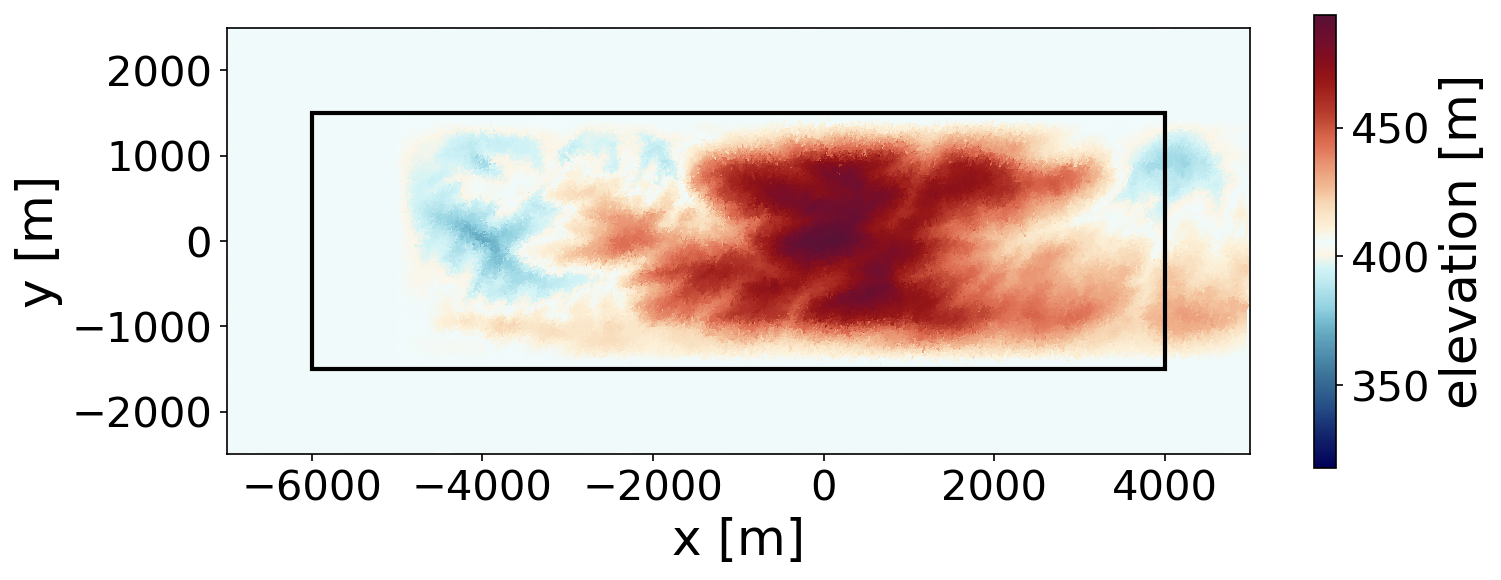

In [299]:
%%time
fig, ax = plt.subplots(figsize=(11,4),dpi=150)
pcm = ax.pcolormesh(newmsh.x, newmsh.y, newmsh.z, cmap=coolwarm_ext,
                    vmin=edge_elev-elev_delta, vmax=edge_elev+elev_delta)
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('elevation [m]',fontsize=24)
cbar.ax.tick_params(labelsize=20) 

rect = patches.Rectangle(
    (xMin,yMin), (xMax-xMin), (yMax-yMin),
    fill=False, clip_on=False, lw=2,
)
ax.add_patch(rect)

ax.set_xlabel('x [m]',fontsize=24)
ax.set_ylabel('y [m]',fontsize=24)
ax.tick_params(labelsize=20)
ax.set_xlim((-6250,4250))
ax.set_ylim((-1750,1750))
ax.axis('scaled')

fig.savefig('simulated_terrain.png',dpi=300,bbox_inches='tight')

In [40]:
np.min(newmsh.z), np.max(newmsh.z)

(370.0, 494.0)

## 3. Sampling

In [41]:
def list_sample_points(x0,y0,z0,Ntabs=3,height=200.,dz=10.,off=0.001):
    z = np.arange(z0,z0+height+dz,dz)
    indent = Ntabs*4*' '
    for zi in z:
        print('{:s}({:g} {:g} {:g})'.format(indent, x0+off, y0+off, zi+off))

In [42]:
list_sample_points(0,0,495)

            (0.001 0.001 495.001)
            (0.001 0.001 505.001)
            (0.001 0.001 515.001)
            (0.001 0.001 525.001)
            (0.001 0.001 535.001)
            (0.001 0.001 545.001)
            (0.001 0.001 555.001)
            (0.001 0.001 565.001)
            (0.001 0.001 575.001)
            (0.001 0.001 585.001)
            (0.001 0.001 595.001)
            (0.001 0.001 605.001)
            (0.001 0.001 615.001)
            (0.001 0.001 625.001)
            (0.001 0.001 635.001)
            (0.001 0.001 645.001)
            (0.001 0.001 655.001)
            (0.001 0.001 665.001)
            (0.001 0.001 675.001)
            (0.001 0.001 685.001)
            (0.001 0.001 695.001)


In [43]:
list_sample_points(-5500,0,406)

            (-5500 0.001 406.001)
            (-5500 0.001 416.001)
            (-5500 0.001 426.001)
            (-5500 0.001 436.001)
            (-5500 0.001 446.001)
            (-5500 0.001 456.001)
            (-5500 0.001 466.001)
            (-5500 0.001 476.001)
            (-5500 0.001 486.001)
            (-5500 0.001 496.001)
            (-5500 0.001 506.001)
            (-5500 0.001 516.001)
            (-5500 0.001 526.001)
            (-5500 0.001 536.001)
            (-5500 0.001 546.001)
            (-5500 0.001 556.001)
            (-5500 0.001 566.001)
            (-5500 0.001 576.001)
            (-5500 0.001 586.001)
            (-5500 0.001 596.001)
            (-5500 0.001 606.001)


## 4. extract terrain transect

In [44]:
xi = newmsh.x.ravel()
yi = newmsh.y.ravel()
zi = newmsh.z.ravel()

In [45]:
trunc = np.where((yi > -100) & (yi < 100))
xi = xi[trunc]
yi = yi[trunc]
zi = zi[trunc]

In [46]:
xo = np.arange(-6000,4001,10)
yo = np.zeros(xo.shape)

In [47]:
from scipy.interpolate import griddata

In [48]:
inpoints = np.stack((xi,yi),axis=-1)
outpoints = np.stack((xo,yo),axis=-1)
zo = griddata(inpoints, zi, outpoints)

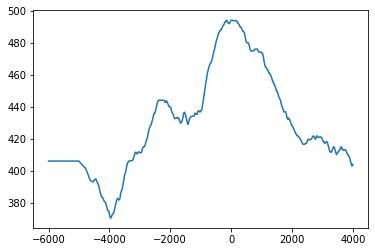

In [49]:
plt.plot(xo,zo)

In [50]:
np.savetxt('terrain_y0.txt', np.stack((xo,zo), axis=-1))

## 5. estimate terrain complexity

### calculate surface unit normals

In [79]:
newmsh.normals.shape

(177956, 3)

In [105]:
%%time
Ntri = len(normals)
unitnormals = newmsh.normals.copy()
mag = np.empty(Ntri)
for i in range(Ntri):
    ni = unitnormals[i,:]
    mag[i] = np.sqrt(ni.dot(ni))
    unitnormals[i,:] = ni / mag[i]

CPU times: user 753 ms, sys: 27.9 ms, total: 781 ms
Wall time: 809 ms


In [116]:
# the surface normals have magnitude 2*A where A is the triangle area (not sure why)
assert np.allclose(mag, 2*newmsh.areas.squeeze())

True

In [123]:
[np.mean(unitnormals[:,i]) for i in range(3)]

[-0.00020691837, -5.8492583e-06, 0.99840444]

### calculate slope

In [117]:
def calc_slope(normals):
    # theta: angle between surface normal (n) and vertical direction
    # n.dot([0,0,1]) == cos(theta)
    # slope == tan(theta)
    return np.tan(np.arccos(normals[:,2]))

In [118]:
%time terrainslope = calc_slope(unitnormals)

CPU times: user 2.65 ms, sys: 788 µs, total: 3.43 ms
Wall time: 2.46 ms


In [152]:
np.max(terrainslope)

0.29882947

CPU times: user 363 ms, sys: 11.7 ms, total: 375 ms
Wall time: 372 ms


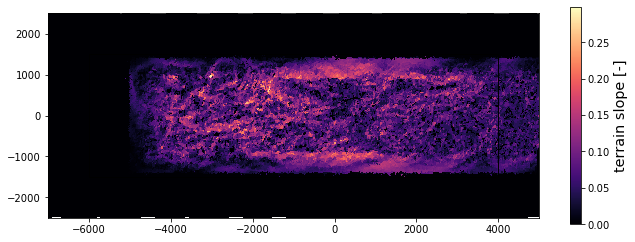

In [153]:
%%time
fig, ax = plt.subplots(figsize=(11,4))
pcm = ax.pcolormesh(newmsh.x, newmsh.y, np.repeat(terrainslope[:,np.newaxis],3,axis=1),
                    cmap='magma')
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('terrain slope [-]',fontsize='x-large')

rect = patches.Rectangle(
    (xMin,yMin), (xMax-xMin), (yMax-yMin),
    fill=False, clip_on=False,
)
ax.add_patch(rect)

ax.set_xlim((xMin,xMax))
ax.set_ylim((yMin,yMax))
ax.axis('scaled')

fig.savefig('simulated_terrain_slope.png')

In [ ]:
def calc_RIX(origin_xy, R=1000., threshold_slope=0.3):
    xi = newmsh.x.ravel()
    yi = newmsh.y.ravel()
    inrange = np.where(np.sqrt((xi-origin_xy[0])**2 + (yi-origin_xy[1])**2) <= R)
    